Load the images from the VISCHEMA dataset

This block assumes you have the "VISCHEMA.zip" and "VISCHEMA_VMS.zip" folders downloaded in the same directory as this file.

In [1]:
#content = '/content/drive/MyDrive/Colab Notebooks/Project/'

content = ''

import torch
from torchvision.datasets.utils import extract_archive
import numpy as np
from PIL import Image
import csv
import os
from torchvision import transforms
import matplotlib.pyplot as plt
import time
from torch.utils.data import Dataset, DataLoader, Subset
from sklearn.model_selection import train_test_split
import sklearn
import random
import torchvision.transforms.functional as F
from torchvision.utils import draw_segmentation_masks, make_grid
import copy
import torchvision.models as models
from torch import optim

#dataset = 'VISCHEMA_PLUS'
dataset = 'VISCHEMA'

if dataset == 'VISCHEMA':
  extract_archive(content+'VISCHEMA.zip','/content')
  extract_archive(content+'VISCHEMA_VMS.zip','/content')

else:
  extract_archive(content+'VISCHEMA_PLUS.zip','/content')

In [ ]:
!pip --version
print(torch.__version__)
print(np.__version__)
print(sklearn.__version__)

pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
1.11.0+cu113
1.21.6
1.0.2


Flatten the directories, load them into memory and convert them to pytorch tensors.

In [2]:
def find_files(directory):
    for d, dirs, files in os.walk(directory):
        for f in files:
            yield os.path.join(d, f)

if dataset == 'VISCHEMA':
  image_gen = find_files('/content/VISCHEMA SUN folders')
  #image_gen = find_files(f'{content}TEST VISCHEMA')
else:
  image_gen = find_files('/content/VISCHEMA_PLUS/images')

PRETRAINED = True
SEGMENTATION = False

if PRETRAINED:  
  if SEGMENTATION: X = Y = 100
  else: X = Y = 224
else:
  X = Y = 160

if SEGMENTATION: vms_x = vms_y = 100
else: vms_x = vms_y = 20

# Resize to 224x224 to use a pretrained model https://pytorch.org/vision/stable/models.html)
if PRETRAINED:
  # Normalise data to [0,1] and normalise mean and std to be used for transfer learning
  if SEGMENTATION:
    transform = transforms.Compose([
      transforms.Resize((X,Y)),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x/255)
    ])
  else:
    transform = transforms.Compose([
      transforms.Resize((X,Y)),
      transforms.ToTensor(),
      transforms.Lambda(lambda x: x/255),
      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225]),
    ])
else:
  transform = transforms.Resize((X,Y))

images = [i for i in image_gen]
# Use custom sorting key to align images with vms, irregardless of directory structure
images.sort(key=lambda x: x.split('/')[-1])

if dataset == 'VISCHEMA':
  classes = [c.split('/')[4] for c in images]
data = [np.asarray(transform(Image.open(f))) for f in images]

data = np.array(data)
data = torch.FloatTensor(data)

if dataset == 'VISCHEMA':
  vms_gen = find_files('/content/VISCHEMA VMS')
else:
  vms_gen = find_files('/content/VISCHEMA_PLUS/vms')
#vms_gen = find_files(f'{content}TEST VISCHEMA VMS')
 
transform = transforms.Resize((vms_x,vms_y))

#Build a list of each unique class, for analysis per class
if dataset == 'VISCHEMA':
  class_list = []
  for x in classes:
    if x not in class_list:
      class_list.append(x)

vms = [v for v in vms_gen]
# Use custom sorting key to align images with vms, irregardless of directory structure
vms.sort(key=lambda x: x.split('/')[-1])

# Use only the coloured vms maps.
# outputs = [(np.asarray(transform(Image.open(f)))/255).flatten() for f in vms if '_S' not in f]

# Use the non-coloured vms maps.
if dataset == 'VISCHEMA':
  outputs = [((np.asarray(transform(Image.open(f))))/255).flatten() for f in vms if '_S' in f]
  vms_names = [f for f in vms if '_S' in f]
else:
  outputs = [((np.asarray(F.to_grayscale(transform(Image.open(f)))))/255).flatten() for f in vms]
  vms_names = [f for f in vms]


outputs = np.array(outputs)
outputs = torch.FloatTensor(outputs)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.cuda.benchmark = True

In [ ]:
print(data.shape,outputs.shape)

torch.Size([800, 3, 224, 224]) torch.Size([800, 400])


Initialise a custom Dataset to store the VISCHEMA images, vms maps and classes.

In [3]:
class VISCHEMA(Dataset):
  def __init__(self,data,vms,filenames=None,classes=None):
    self.data = data
    self.vms = vms
    self.classes = classes
    self.filenames = [f.split('/')[-1] for f in filenames]
  def __len__(self):
    return self.data.shape[0]
  def __getitem__(self,id):
    image = (self.data[id,:,:]).unsqueeze(0)
    if self.vms == None: return image
    else: vms = self.vms[id]
    if self.classes == None: return image, vms
    elif classes != None:
      return image, vms, self.filenames[id], self.classes[id]
    else:
      return image, vms, self.filenames[id]

# Use 20% of the dataset (160 images for VISCHEMA) for testing. 
TEST_SIZE = 0.25
# Use 5% of the dataset (40 images for VISCHEMA) for validation.
VAL_SIZE = 0.05
BATCH_SIZE = 4

RANDOM_TRANSFORM = False


if dataset == 'VISCHEMA':
  full_dataset = VISCHEMA(data,outputs,vms_names,classes)
else:
  full_dataset = VISCHEMA(data,outputs,vms_names)

# Perform a stratified train - test - validation split on our dataset, such that both sets should have a similar amount of samples from each class.

# Split into train and test + val
if dataset == 'VISCHEMA':
  train_indices, test_val_indices, _, test_val_classes = train_test_split(range(data.shape[0]),classes,stratify=classes,test_size=TEST_SIZE+VAL_SIZE)

  train_split = Subset(full_dataset,train_indices)

  # Split test + val into test and val
  test_indices, val_indices, test_classes, val_classes = train_test_split(test_val_indices, test_val_classes, stratify=test_val_classes, test_size=VAL_SIZE/TEST_SIZE)


  test_split = Subset(full_dataset,test_indices)
  val_split = Subset(full_dataset,val_indices)

else:
  train_indices, test_val_indices, _, test_val_names = train_test_split(range(data.shape[0]),vms_names,stratify=None,test_size=TEST_SIZE+VAL_SIZE)

  train_split = Subset(full_dataset,train_indices)

  # Split test + val into test and val
  test_indices, val_indices, _, _ = train_test_split(test_val_indices, test_val_names, stratify=None, test_size=VAL_SIZE/TEST_SIZE)


  test_split = Subset(full_dataset,test_indices)
  val_split = Subset(full_dataset,val_indices)

# Initialise DataLoaders for train,test and validation batches.

dataloaders = {'train':DataLoader(train_split, batch_size=BATCH_SIZE,shuffle=True,num_workers=1),
               'test':DataLoader(test_split, batch_size=BATCH_SIZE,shuffle=True,num_workers=1),
               'val':DataLoader(val_split, batch_size = len(val_split), shuffle=True,num_workers=1)}

dataset_sizes = {'train': len(train_split), 'test': len(test_split), 'val': len(val_split)}

In [4]:
# Crops the image and vms randomly, while keeping them consistent with one another.
def random_transform(image, vms):
  vms = transforms.functional_tensor.resize(vms[:].cpu().squeeze().reshape((vms_x, vms_y)).unsqueeze(0),(X,Y)).squeeze(0)
  rnd_width = rnd_height = random.randint(180,X) 

  rnd_x = random.randint(0,X - rnd_width)
  rnd_y = random.randint(0,Y - rnd_height)

  image = transforms.functional_tensor.crop(image, rnd_y, rnd_x, rnd_height, rnd_width)
  vms = transforms.functional_tensor.crop(vms, rnd_y, rnd_x, rnd_height, rnd_width)

  image = transforms.functional_tensor.resize(image.unsqueeze(0), X).squeeze(0)
  vms = transforms.functional_tensor.resize(vms.unsqueeze(0), vms_x).squeeze(0)

  vms = torch.flatten(vms)
  return image,vms

In [5]:
def show_images(num, model=None, r_transform=False):
  if model != None:
    was_training = model.training
    model.eval()

  
  image_count = 0
  fig = plt.figure(time.time(), figsize=(15,15))
  cols = rows = int(np.sqrt(num))
  transform = transforms.Resize((X,Y))
  invNormalise = transforms.Compose([transforms.Normalize(mean = [0., 0., 0.],
                                                          std = [1/0.229, 1/0.224, 1/0.225]),
                                     transforms.Normalize(mean = [-0.485, -0.456, -0.406],
                                                          std = [1., 1., 1.])])
  mul_255 = transforms.Lambda(lambda x: x*255)

  with torch.no_grad():
    if dataset == 'VISCHEMA':
      for _, (inputs, vms, labels, _) in enumerate(dataloaders['val']):
        
        if model != None:
          inputs = inputs[:,0,:,:,:].to(device)
          vms = vms.to(device)
          

          outputs = model(inputs)
          if r_transform:
            for i in range(inputs.shape[0]):
              inputs[i,:,:,:],outputs[i,:] = random_transform(inputs[i],outputs[i])
        for i in range(num):
          fig.add_subplot(rows, cols*2, i+1)
          if model != None:
            plt.title(f'Loss: {criterion(mul_255(outputs[i]), mul_255(vms[i]))} ',color='black')
          plt.axis("off")
          # Display image
          plt.imshow(np.asarray(((invNormalise(inputs[i,:].cpu()))).squeeze().permute(1,2,0))*255)
          # We need to convert vms array to image so it can be resized.
          if model:
            vms_image = Image.fromarray(np.asarray(outputs[i,:].cpu().squeeze()*255).reshape((vms_x,vms_y)).astype(np.uint8))
          else:
            vms_image = Image.fromarray(np.asarray(vms[i,:].cpu().squeeze()*255).reshape((vms_x,vms_y)).astype(np.uint8))
          # Display vms
          plt.imshow(transform(vms_image),alpha=0.3,cmap='jet')
        plt.show()
        if model:
          model.train(mode=was_training)
        break
    else:
      for _, (inputs, vms) in enumerate(dataloaders['val']):
        
        if model != None:
          inputs = inputs[:,0,:,:,:].to(device)
          vms = vms.to(device)
          

          outputs = model(inputs)
          if r_transform:
            for i in range(inputs.shape[0]):
              inputs[i,:,:,:],outputs[i,:] = random_transform(inputs[i],outputs[i])
          
        for i in range(num):
          fig.add_subplot(rows, cols*2, i+1)
          if model != None:
            plt.title(f'Loss: {criterion(mul_255(outputs[i]), mul_255(vms[i]))} ',color='black')
          plt.axis("off")
          # Display image
          plt.imshow(np.asarray(((invNormalise(inputs[i,:].cpu()))).squeeze().permute(1,2,0))*255)
          # We need to convert vms array to image so it can be resized.
          if model:
            vms_image = Image.fromarray(np.asarray(outputs[i,:].cpu().squeeze()*255).reshape((vms_x,vms_y)).astype(np.uint8))
          else:
            vms_image = Image.fromarray(np.asarray(vms[i,:].cpu().squeeze()*255).reshape((vms_x,vms_y)).astype(np.uint8))
          # Display vms
          plt.imshow(transform(vms_image),alpha=0.3,cmap='jet')
        plt.show()
        if model:
          model.train(mode=was_training)
        break



In [ ]:
def show_imgs(num, model):
  if model != None:
    was_training = model.training
    model.eval()

  with torch.no_grad():
    for _, (inputs, vms, labels, _) in enumerate(dataloaders['test']):

      if model != None:
        inputs = inputs[:,0,:,:,:].to(device)
        vms = vms.to(device)
        outputs = model(inputs)
        outputs = model(inputs)['out']
        outputs = (outputs.argmax(1) == 1)
        imgs_with_masks = [
          draw_segmentation_masks((img.cpu()*255).squeeze().to(torch.uint8), masks=mask, alpha=0.7)
          for img, mask in zip(inputs, outputs)
        ]
        show(imgs_with_masks)
      if model:
        model.train(mode=was_training)
      break
  

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])



Visualise some sample images with the VMS overlayed.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


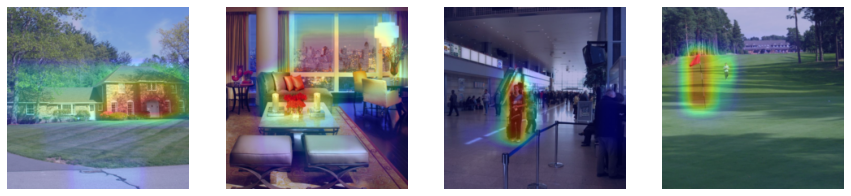

In [ ]:
import matplotlib.pyplot as plt

show_images(4, r_transform=True)

Set up model to use for transfer learning

In [6]:
def initialise_network(base_lr=0.00001, lr=0.001, layer1=512, layer2=0, layer3=0):
  if SEGMENTATION:
    model = models.segmentation.fcn_resnet101(pretrained=True)
    model.classifier = torch.nn.Sequential(
        torch.nn.Conv2d(2048,2048,kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
        torch.nn.BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.1, inplace=False),
        torch.nn.Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1)),
        torch.nn.Conv2d(1024,512,kernel_size=(3,3), stride=(1,1), padding=(1,1), bias=False),
        torch.nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
        torch.nn.ReLU(),
        torch.nn.Dropout(p=0.1, inplace=False),
        torch.nn.Conv2d(512, 2, kernel_size=(1, 1), stride=(1, 1)))
    
    for param in model.parameters():
      param.requires_grad = True

    criterion = torch.nn.CrossEntropyLoss()
    params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in (model.classifier.parameters() or model.classifier.aux_parameters()), model.named_parameters()))))
    base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in (model.classifier.parameters() or model.classifier.aux_parameters()), model.named_parameters()))))
    vms_threshold = 0.5

  else:
    model = models.resnet50(pretrained=True)
    
    batchnorm = []
    bn2d = [module for module in model.modules() if type(module) == torch.nn.BatchNorm2d]
    for module in bn2d:
      for param in module.parameters():
        batchnorm.append(param)
        
    for param in model.parameters():
      param.requires_grad = True

    fc_ftrs = model.fc.in_features

    if layer1==0 and layer2==0 and layer3==0:
      model.fc = torch.nn.Sequential(
          torch.nn.Linear(fc_ftrs,vms_x*vms_y),
          #torch.nn.Dropout(p=0.1),
          torch.nn.Sigmoid()
      )
    elif layer2==0 and layer3==0:
      model.fc = torch.nn.Sequential(
          torch.nn.Linear(fc_ftrs,layer1),
          #torch.nn.Dropout(p=0.1),
          torch.nn.ReLU(),
          torch.nn.Linear(layer1,vms_x*vms_y),
          #torch.nn.Dropout(p=0.1),
          torch.nn.Sigmoid()
      )
    elif layer3==0:
      model.fc = torch.nn.Sequential(
          torch.nn.Linear(fc_ftrs,layer1),
         # torch.nn.Dropout(p=0.1),
          torch.nn.ReLU(),
          torch.nn.Linear(layer1,layer2),
          #torch.nn.Dropout(p=0.1),
          torch.nn.ReLU(),
          torch.nn.Linear(layer2,vms_x*vms_y),
          #torch.nn.Dropout(p=0.1),
          torch.nn.Sigmoid()
      )
    else:
      model.fc = torch.nn.Sequential(
          torch.nn.Linear(fc_ftrs,layer1),
          #torch.nn.Dropout(p=0.1),
          torch.nn.ReLU(),
          torch.nn.Linear(layer1,layer2),
          #torch.nn.Dropout(p=0.1),
          torch.nn.ReLU(),
          torch.nn.Linear(layer2,layer3),
          #torch.nn.Dropout(p=0.1),
          torch.nn.ReLU(),
          torch.nn.Linear(layer3,vms_x*vms_y),
          #torch.nn.Dropout(p=0.1),
          torch.nn.Sigmoid()
      ) 

    params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in model.fc.parameters(), model.named_parameters()))))
    base_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] not in model.fc.parameters(), model.named_parameters()))))
    batchnorm_params = list(map(lambda x: x[1],list(filter(lambda kv: kv[0] in batchnorm, model.named_parameters()))))
    criterion = torch.nn.MSELoss()

  model = model.to(device)

  optimiser = optim.SGD([{"params" : base_params, "lr": base_lr, "momentum":0.9},
                         {"params" : batchnorm_params, "lr" : lr, "momentum" : 1},
                         {"params" : params, "lr": lr, "momentum":1}])

  exp_lr_scheduler = optim.lr_scheduler.StepLR(optimiser, step_size=5, gamma=0.9)

  return model, optimiser, exp_lr_scheduler, criterion

In [8]:
def train_model(model, criterion, optimiser, scheduler, epochs=25, base_lr=0.00001, lr=0.001):
  start = time.time()
  best_weights = copy.deepcopy(model.state_dict())
  best_loss = None
  loss_list = [[],[]]
  epoch_list = [[],[]]
  transform = transforms.Lambda(lambda x: x*255)
  for epoch in range(epochs+1):
    print(f'Epoch {epoch}/{epochs}\n---------------\n')

    for phase in ['train', 'test']:
      if phase == 'train':
        model.train()
      else: model.eval()

      tot_loss = 0.0
      if dataset == 'VISCHEMA':
        for inputs, vms, labels, _ in dataloaders[phase]:
          inputs = inputs[:,0,:,:,:].to(device)
          
          if SEGMENTATION: vms = (vms.to(device) > vms_threshold).float()
          else: vms = vms.to(device)
          
          if RANDOM_TRANSFORM and phase == 'train':
            for i in range(inputs.shape[0]):
              inputs[i,:,:,:],vms[i,:] = random_transform(inputs[i],vms[i])

          optimiser.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            if SEGMENTATION:
              outputs = model(inputs)['out']
              outputs = (outputs.argmax(1)).to(float)
              loss = criterion(outputs, vms)
            
            else:
              outputs = model(inputs)
              loss = criterion(transform(outputs), transform(vms))
            
            if phase == 'train':
              loss.backward()
              optimiser.step()

          tot_loss += loss.item() * inputs.size(0)
      else:
        for inputs, vms, in dataloaders[phase]:
          inputs = inputs[:,0,:,:,:].to(device)
          
          if SEGMENTATION: vms = (vms.to(device) > vms_threshold).float()
          else: vms = vms.to(device)
          
          if RANDOM_TRANSFORM and phase == 'train':
            for i in range(inputs.shape[0]):
              inputs[i,:,:,:],vms[i,:] = random_transform(inputs[i],vms[i])

          optimiser.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
            if SEGMENTATION:
              outputs = model(inputs)['out']
              outputs = (outputs.argmax(1)).to(float)
              loss = criterion(outputs, vms)
            
            else:
              outputs = model(inputs)
              loss = criterion(transform(outputs), transform(vms))
            
            if phase == 'train':
              loss.backward()
              optimiser.step()

          tot_loss += loss.item() * inputs.size(0)

      if phase == 'train':
        scheduler.step()
      epoch_loss = tot_loss / dataset_sizes[phase]
      if phase == 'train':
        loss_list[0].append(epoch_loss)
        epoch_list[0].append(epoch)
      else:
        loss_list[1].append(epoch_loss)
        epoch_list[1].append(epoch)

      print(f'{phase} loss: {epoch_loss:.4f}\n')
      if phase == 'test' and (best_loss == None or best_loss > epoch_loss):
        best_loss = epoch_loss
        best_weights = copy.deepcopy(model.state_dict())
  model.load_state_dict(best_weights)

  plt.plot(epoch_list[0],loss_list[0],label="Train")
  plt.plot(epoch_list[1],loss_list[1],label="Test")
  plt.legend()
  plt.xlabel("Epoch")
  plt.ylabel("MSE Loss")
  plt.savefig(f'{content}vischema-20%-resnet50-batch16-input-512-output-(lr={lr}&{base_lr})-(stepsize=25&gamma=0.95).pdf')
  plt.show()
  
  return model

Epoch 0/100
---------------

train loss: 3457.1843

test loss: 2615.9889

Epoch 1/100
---------------

train loss: 2499.1351

test loss: 2805.5553

Epoch 2/100
---------------

train loss: 2522.4759

test loss: 2517.6326

Epoch 3/100
---------------

train loss: 2460.5489

test loss: 2632.1054

Epoch 4/100
---------------

train loss: 2482.6511

test loss: 2507.3648

Epoch 5/100
---------------

train loss: 2457.6257

test loss: 2521.5338

Epoch 6/100
---------------

train loss: 2475.6893

test loss: 2610.2209

Epoch 7/100
---------------

train loss: 2441.1499

test loss: 2911.1826

Epoch 8/100
---------------

train loss: 2449.8587

test loss: 2552.6683

Epoch 9/100
---------------

train loss: 2448.0248

test loss: 2588.4577

Epoch 10/100
---------------

train loss: 2434.4963

test loss: 2651.4373

Epoch 11/100
---------------

train loss: 2441.2120

test loss: 2581.2215

Epoch 12/100
---------------

train loss: 2435.6457

test loss: 2576.9090

Epoch 13/100
---------------

train

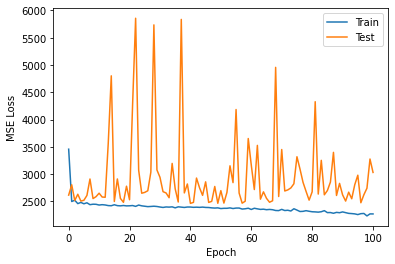

In [9]:
lrs = [0.0003]
base_lrs = [0.00003]

for lr in lrs:
  for blr in base_lrs:
    model,optimiser,exp_lr_scheduler,criterion = initialise_network(base_lr=blr, lr=lr, layer1=512)
    model = train_model(model, criterion, optimiser, exp_lr_scheduler, epochs=100, base_lr=blr, lr=lr)

In [ ]:
show_images(4,model)

NameError: ignored

{'airport_terminal': 3, 'conference_room': 3, 'kitchen': 3, 'living_room': 3, 'amusement_park': 1, 'golf_course': 2, 'badlands': 1, 'playground': 2, 'house': 2, 'mountain': 1, 'pasture': 1, 'skyscraper': 1}


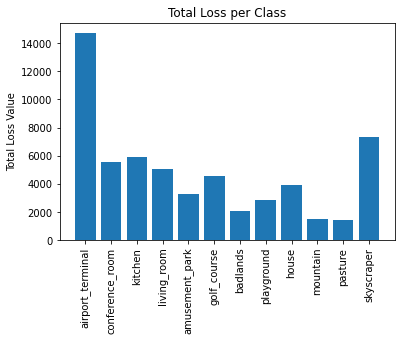

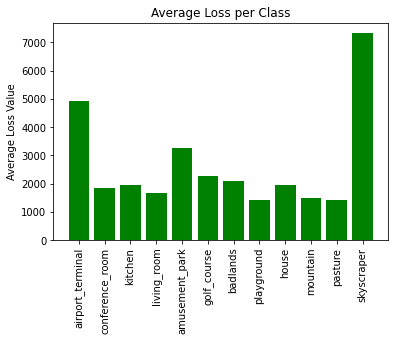

In [ ]:
avg_loss = {}
tot_loss = {}
counts = {}

was_training = model.training
model.eval()

mul_255 = transforms.Lambda(lambda x: x*255)

for x in class_list:
  avg_loss.update({x: 0})
  tot_loss.update({x: 0})
  counts.update({x: 0})

with torch.no_grad():
  for _, (inputs, vms, _, labels) in enumerate(dataloaders['val']):
    inputs = inputs[:,0,:,:,:].to(device)
    vms = vms.to(device)
    outputs = model(inputs)

    for i in range(inputs.shape[0]):
      counts.update({labels[i]: counts.get(labels[i]) + 1})
      tot_loss.update({labels[i]: tot_loss.get(labels[i]) + criterion(mul_255(outputs[i]), mul_255(vms[i])).item()})
      
  model.train(mode=was_training)


for x in avg_loss:
  avg_loss.update({x: tot_loss.get(x)/counts.get(x)})

print(counts)

tot_loss_values = list(tot_loss.values())
avg_loss_values = list(avg_loss.values())

plt.xticks(rotation=90)
plt.ylabel("Total Loss Value")
plt.title("Total Loss per Class")
plt.bar(class_list, tot_loss_values)
plt.show()

plt.xticks(rotation=90)
plt.title("Average Loss per Class")
plt.ylabel("Average Loss Value")
plt.bar(class_list, avg_loss_values,color='green')
plt.show()

In [ ]:
def save_vms(model):
  was_training = model.training
  model.eval()
  with torch.no_grad():
    for _, (inputs, vms, filenames, labels) in enumerate(dataloaders['val']):
      inputs = inputs[:,0,:,:,:].to(device)
      vms = vms.to(device)
      outputs = model(inputs)

      for i in range(len(outputs)):
        output = Image.fromarray(np.asarray(outputs[i,:].cpu().squeeze()*255).reshape((vms_x, vms_y)).astype(np.uint8))
        output.save(f'{content}output_vms/{filenames[i]}')
        print(f'Image saved at {content}output_vms/{filenames[i]}')


  model.train(was_training)